Load the dataset - 'train.csv' \
Each raw in the file contains the following values of weather value. 
- first column -> Continent
- second column -> Season
- third column -> Wind Speed
- fourth column -> Location
- fifth column -> Weather
- sixth column -> Temperature

In [20]:
import math

import random

from collections import defaultdict

import time

import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
def load_data(path):
    with open(path) as f:
        lines = f.readlines()
    
    data_x = []
    data_y = []
    
    for line in lines:
        line = list(map(str.strip, line.split(',')))    
        
        data_x.append(line[:5])
        data_y.append(line[5])
        
    return data_x, data_y

In [22]:
train_x, train_y = load_data('dataset/train.csv')
validate_x, validate_y = load_data('dataset/validate.csv')
test_x, test_y = load_data('dataset/train.csv')

len(train_x), len(train_y)

(107, 107)

In [23]:
# Encode features

unique_country = {}
unique_season = {}
unique_windspeed = {}
unique_location = {}
unique_weather = {}

unique_temperature = {}


for country, season, windspeed, location, weather in train_x:
    if country not in unique_country:
        unique_country[country] = len(unique_country)
    
    if season not in unique_season:
        unique_season[season] = len(unique_season)
    
    if windspeed not in unique_windspeed:
        unique_windspeed[windspeed] = len(unique_windspeed)
    
    if location not in unique_location:
        unique_location[location] = len(unique_location)
    
    if weather not in unique_weather:
        unique_weather[weather] = len(unique_weather)    
            

for temp in train_y:
    if temp not in unique_temperature:
        unique_temperature[temp] = len(unique_temperature)
    
    
unique_country, unique_season, unique_windspeed, unique_location, unique_weather,  unique_temperature

({'Africa': 0, 'Australia': 1, 'North America': 2},
 {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3},
 {'High': 0, 'Low': 1, 'Normal': 2},
 {'Coast Line': 0, 'Coastline': 1, 'Inland': 2},
 {'Rainy': 0, 'Sunny': 1, 'Cloudy': 2, 'Humid': 3},
 {'Normal': 0, 'Hot': 1, 'Cold': 2})

In [24]:
def featureize(input_x, input_y):
    # one hot encode for features
    
    country = [0] * len(unique_country)    
    season = [0] * len(unique_season)
    windspeed = [0] * len(unique_windspeed)
    location = [0] * len(unique_location)
    weather = [0] * len(unique_weather)
    
    c_idx = unique_country[input_x[0]]
    s_idx = unique_season[input_x[1]]
    w_idx = unique_windspeed[input_x[2]]
    l_idx = unique_location[input_x[3]]
    weather_idx = unique_weather[input_x[4]]
    
    country[c_idx] = 1
    season[s_idx] = 1
    windspeed[w_idx] = 1
    location[l_idx] = 1
    weather[weather_idx] = 1
    
    feature_x = country + season + windspeed + location + weather
    label_y = unique_temperature[input_y]
    
    return feature_x, label_y

In [25]:
def sigmoid_scalar(x):
    # to avoid overflow
    if x < 0:
        sigmoid = math.exp(x) / (1 + math.exp(x))
    else:
        sigmoid = 1 / (1 + math.exp(-x))

    # to handle machine precision errors
    sigmoid = max(0.0001, sigmoid)
    sigmoid = min(0.9999, sigmoid)

    return sigmoid

In [26]:
def argmax(values):
    max_value = float('-inf')
    max_index = 0

    for idx, value in enumerate(values):
        if value > max_value:
            max_index = idx
            max_value = value

    return max_index

In [27]:
def predict(sample_x, weights):
    # calculate z = sum(w * x + b)
    # here bias (b) is also included in weights
    z = 0
    for x, w in zip(sample_x, weights):
        z += w * x

    # sigmoid(z)
    return sigmoid_scalar(z)

In [28]:
def cross_entropy_loss(predicted_value, actual_value):
    y = actual_value
    y_pred = predicted_value    

    if y == 1:        
        return -math.log(y_pred)

    else:        
        return -math.log(1 - y_pred)

In [29]:
def gradient_decent(X, label, weights=None, learning_rate=0.1):
    n_features = len(X[0])

    # initialize weight with random values (equal length to x's features)
    if weights == None:
        weights = [random.random() for _ in range(n_features)]

    loss = 0

    for x, y in zip(X, label):
        y_pred = predict(x, weights)
        loss += cross_entropy_loss(y_pred, y)

        # dw = (y_pred - y) * x
        # weight = weight - learning_rate * dw
        err = y_pred - y
        for i in range(n_features):
            dw_i = err * x[i]
            weights[i] -= learning_rate * dw_i

    return weights, loss / len(X)

In [30]:
def train_binary_class(x_train, y_train, learning_rate, epoch, verbose=False):
    weights = None

    # for graphing
    history = []

    for i in range(epoch):
        weights, loss = gradient_decent(x_train, y_train, weights, learning_rate)

        history.append(loss)

        if verbose:
            print(f"Epoch [{i}]\n\t- Cross entropy loss: {loss}\n")

    return weights, history

In [31]:
def train_multiclass(x_train, y_train, learning_rate, epoch, verbose=False):
    # identify unique classes
    classes = range(0, len(unique_temperature))

    # for each class create separate labels suitable for binary classification
    labels = [[] for _ in classes]

    for class_ in classes:
        for label in y_train:            
            if label == class_:
                labels[class_].append(1)

            else:
                labels[class_].append(0)
    
    # now that we have separate labels for each class
    # lets train binary classifier for each class
    # (each classifier will identify whether sample x is member of class or not)

    
    classifiers = [None] * len(unique_temperature)
    histories = [None] * len(unique_temperature)

    for cls_, label in enumerate(labels):
        if verbose:
            print(f'Training class [{cls_}]')

        weights, history = train_binary_class(x_train, label, learning_rate, epoch)        

        classifiers[cls_] = weights
        histories[cls_] = history

        if verbose:
            print('---------------------------------------------------------------------')
    

    return classifiers, histories

In [32]:
def predict_class(sample_x, model):
    class_probabilities = []
    
    for weights in model:
        class_probability = predict(sample_x, weights)
        class_probabilities.append(class_probability)
    
    return argmax(class_probabilities)

In [33]:
def test(test_x, label, model):    
    net_accuracy = 0

    for i in range(len(test_x)):
        prediction = predict_class(test_x[i], model)        

        if prediction == label[i]:
            net_accuracy += 1              

    return net_accuracy / len(test_x)


In [34]:
x_train_set = []
y_train_set = []

for x, y in zip(train_x, train_y):
    x, y = featureize(x, y)
    x_train_set.append(x)
    y_train_set.append(y)


In [35]:
x_validation_set = []
y_validation_set = []

for x, y in zip(validate_x, validate_y):
    x, y = featureize(x, y)
    x_validation_set.append(x)
    y_validation_set.append(y)

In [36]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]

epochs = 1000

histories = []

models = []

for eta in learning_rates:
    print(f'Learning rate: {eta}')

    start_time = time.perf_counter()

    model, history = train_multiclass(x_train_set, y_train_set, eta, epochs, verbose=True)

    time_taken = time.perf_counter() - start_time  
    
    models.append(model)
    
    histories.append(
      (   time_taken,
          histories,
          test(x_validation_set, y_validation_set, model)
      )
    )


Learning rate: 0.0001
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Learning rate: 0.001
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Learning rate: 0.01
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Learning rate: 0.1
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------

In [37]:
x_test_set = []
y_test_set = []

for x, y in zip(test_x, test_y):
    x, y = featureize(x, y)
    x_test_set.append(x)
    y_test_set.append(y)


In [38]:
accuracy = []

for i in range(len(learning_rates)):        
    
    acc = test(x_test_set, y_test_set, models[i])
    
    accuracy.append(acc)

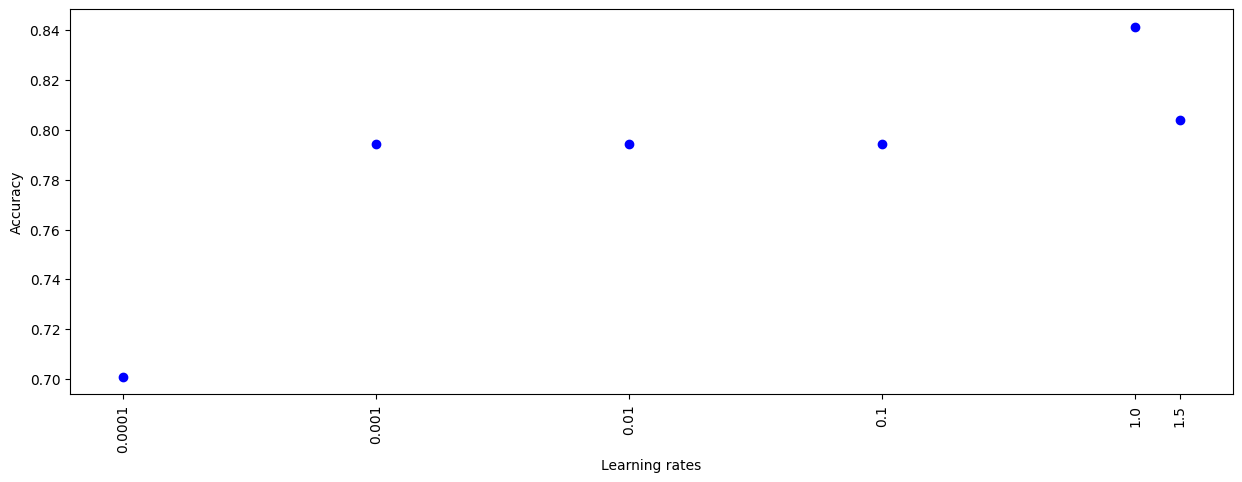

In [39]:
plt.rcParams["figure.figsize"] = (15,5)

plt.plot(list(map(math.log, learning_rates)), accuracy, 'bo')
plt.xlabel('Learning rates')
plt.ylabel('Accuracy')
plt.xticks(list(map(math.log, learning_rates)), labels=learning_rates, rotation=90)

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [40]:
accuracy

[0.7009345794392523,
 0.794392523364486,
 0.794392523364486,
 0.794392523364486,
 0.8411214953271028,
 0.8037383177570093]